# Global and Local Explanation for CNN model on MIT shifted data with binary target variable

Input files:  
Mode: `model_mit_binary_shift_cnn.h5` generated in notebook `modeling_mit_binary_shift_CNN.ipynb`     

Dataset: Binary classification datate genereted in notebook `preprocessing_mit_binary_shift_minmax_oversampling.ipynb` 


mitbih_binary_train_shift_minmax_oversampling.csv \
mitbih_binary_test_shift_minmax_oversampling.csv  

In [13]:
import sys
import os 

data_path = ''
model_output_path = ''
# check if the enviorment is Google Colab 

if 'google.colab' in sys.modules:
    print("Running on Google Colab")
    # Install required libraries
    !pip install scikit-learn -q
    !pip install pandas -q
    !pip install numpy -q
    !pip install imbalanced-learn -q

    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    # set the path where the csv file stored in your google drive. 
    data_path = '/content/drive/MyDrive/Heartbeat_Project/'
    #model_output_path = data_path
    model_path = data_path + 'model_mit_dnn_shift.h5' # pkl'

else:
    print("Running on local environment")

    current_path = os.getcwd()
    print("Current working directory:", current_path)
    data_path = '../data/processed/'
    model_output_path = '../models/'
    model_path = '../models/' + 'model_mit_binary_shift_cnn.h5' 

Running on local environment
Current working directory: c:\Users\igurs\Documents\GitHub\heartbeat-analysis-ai\notebooks


In [14]:
# Verify installation and import libraries
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import shap
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
import lime
import lime.lime_tabular

## load data

In [15]:
RawFiles = dict({
    'train': data_path + 'mitbih_binary_train_shift_minmax_oversampling.csv', 
    'test': data_path + 'mitbih_binary_test_shift_minmax_oversampling.csv '  
}) 

train = pd.read_csv(RawFiles.get('train'),sep=',',header=0)
test = pd.read_csv(RawFiles.get('test'),sep=',',header=0)

y_train = train['target']
X_train = train.drop('target', axis=1)

y_test = test['target']
X_test = test.drop('target', axis=1)

## load model

In [16]:
# # Define model_path based on model_output_path
# model_path = model_output_path + 'model_mit_dnn.pkl'

# # Load the DNN model from the pickle file
# with open(model_path, 'rb') as file:
#     dnn_model = pickle.load(file)

# # Check the type of the model (Sequential)
# print(f"Model type: {type(dnn_model)}")

# # Print the summary of the DNN model to understand its architecture
# dnn_model.summary()

# Load and compile the model
try:
    loaded_model = load_model(model_path, compile=False)
except OSError as e:
    print(f"Error loading model: {e}")
    sys.exit("Check model path and try again.")

# Compile the model (ensuring metrics match expected inputs)
loaded_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC'])


# Evaluate the model
evaluation_metrics = loaded_model.evaluate(X_test, y_test, verbose=0)

print(f"Model Evaluation - Loss: {evaluation_metrics[0]}, Accuracy: {evaluation_metrics[1]}, AUC: {evaluation_metrics[2]}")


Model Evaluation - Loss: 0.06994637101888657, Accuracy: 0.9795898199081421, AUC: 0.9919231534004211


### In the following we apply explanation strategies (SHAP, LIME) on the resampled (Oversampling) and rescaled (MinMax Scaler) and shifted dataset to explain the most important features within the CNN model due to to given strategies:

## SHAP Values

In [22]:
import shap

# Reshape X_train and X_test to match the expected input shape of the model
background = X_train.sample(1000, random_state=42).values.reshape(-1, X_train.shape[1], 1)
X_test_array = X_test.values.reshape(-1, X_test.shape[1], 1)


In [23]:
# Initialize DeepExplainer with reshaped background data
explainer = shap.DeepExplainer(loaded_model, background)

# Compute SHAP values for test data
shap_values = explainer.shap_values(X_test_array)

# Visualize SHAP values (e.g., summary plot)
shap.summary_plot(shap_values[0], X_test_array.squeeze(), feature_names=X_test.columns)


c:\Users\igurs\anaconda3\envs\datascientest_evn\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1000, 187, 1))']
  warnings.warn(msg)


KeyboardInterrupt: 

In [24]:
if isinstance(shap_values, list):
    shap_values = shap_values[0]

# Calculate mean absolute SHAP values across all test samples for each feature
mean_shap_values = np.mean(np.abs(shap_values), axis=0)

# Verify that mean_shap_values is 1-dimensional
print("Shape of mean_shap_values before flattening:", mean_shap_values.shape)
if mean_shap_values.ndim > 1:
    mean_shap_values = mean_shap_values.flatten()  # Flatten if it's multi-dimensional
print("Shape of mean_shap_values after flattening:", mean_shap_values.shape)

# Verify the number of features matches
print("Number of features (X_test.columns):", len(X_test.columns))
print("Length of mean_shap_values:", len(mean_shap_values))

# Ensure lengths match before creating DataFrame
if len(mean_shap_values) == len(X_test.columns):
    # Create DataFrame for feature importance
    shap_importance_df = pd.DataFrame({
        'feature': X_test.columns,
        'importance': mean_shap_values
    })

    # Sort by importance and display top features
    shap_importance_df = shap_importance_df.sort_values(by='importance', ascending=False)
    print("Top 10 most important features based on SHAP values:\n", shap_importance_df.head(10))
    

NameError: name 'shap_values' is not defined

In [ ]:
# Plot the top 10 most important features
plt.figure(figsize=(12, 8))
sns.barplot(
    x='importance', 
    y='feature', 
    data=shap_importance_df.head(10), 
    palette='viridis'
)
plt.title('SHAP: Top 10 Most Important Features for DNN Model')
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Features')
plt.show()


## LIME


True Label for selected instance: 0.0
Instance features:
 c_0      0.0
c_1      0.0
c_2      0.0
c_3      0.0
c_4      0.0
        ... 
c_182    0.0
c_183    0.0
c_184    0.0
c_185    0.0
c_186    0.0
Name: 200, Length: 187, dtype: float64


c:\Users\igurs\anaconda3\envs\datascientest_evn\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\igurs\anaconda3\envs\datascientest_evn\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\igurs\anaconda3\envs\datascientest_evn\Lib\site-packages\lime\lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels 

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\igurs\anaconda3\envs\datascientest_evn\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\igurs\anaconda3\envs\datascientest_evn\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\igurs\anaconda3\envs\datascientest_evn\Lib\site-packages\lime\lime_tabular.py:427: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels 

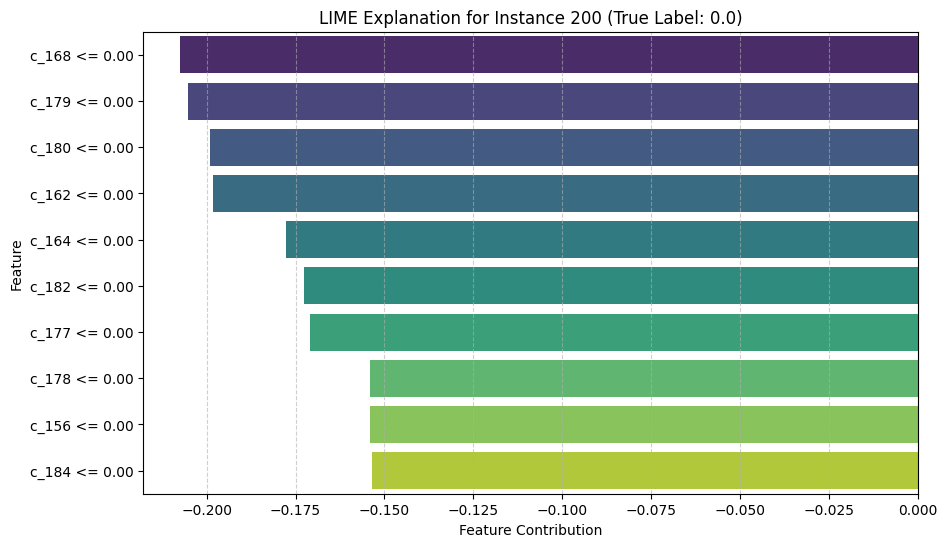

In [25]:
# Wrapper function for predict_proba behavior
def predict_proba_wrapper(data):
    # Predict using the model (outputs probabilities for binary classification)
    predictions = loaded_model.predict(data)
    # Reshape predictions to have two columns for binary classification: [1 - prediction, prediction]
    return np.column_stack([1 - predictions, predictions])

# Initialize the LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),  # Features from the training data
    training_labels=np.array(y_train),  # Target labels for training data
    mode="classification",  # Set to 'classification' for binary classification
    feature_names=X_train.columns,  # Feature names
    class_names=['Class 0', 'Class 1'],  # Class names for binary classification
    discretize_continuous=True  # Discretizes continuous features
)

# Select a random instance from the test set
idx = 200  # You can change this index to select a different instance
instance = X_test.iloc[idx]  # The input instance
true_label = y_test.iloc[idx]

print("True Label for selected instance:", true_label)
print("Instance features:\n", instance)

# Explain the instance using the LIME explainer
exp = explainer.explain_instance(
    data_row=instance,  # Instance to explain
    predict_fn=predict_proba_wrapper,  # Use the wrapper function here
    num_features=10  # Number of features to include in the explanation
)

# Extract feature contributions from the explanation object
feature_importance = exp.as_list()  # Returns a list of (feature, contribution) tuples

# Convert the feature importance to a DataFrame for easy visualization
lime_df = pd.DataFrame(feature_importance, columns=['Feature', 'Contribution'])

# Plot the LIME explanation using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Contribution', 
    y='Feature', 
    data=lime_df, 
    palette='viridis', 
    orient='h'
)
plt.title(f'LIME Explanation for Instance {idx} (True Label: {true_label})')
plt.xlabel('Feature Contribution')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()


In [26]:
from datetime import datetime
# Display the running time
print("Current time:", datetime.now())

Current time: 2024-12-12 19:15:07.285615
